# Задача 6. Компьютерное зрение: задача сегментации

- Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- Попробовать улучшить качество изменяя архитектуру.

In [1]:
import copy
import random
from pathlib import Path

import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
import torchmetrics
from matplotlib import pyplot as plt
from torch import nn
from torchvision import io
from torchvision import transforms
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange

In [2]:
def reset_random_seeds():
    torch.manual_seed(121)
    random.seed(121)

## Реализация U-Net

In [3]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, padding: int):
        super().__init__()
        self.double_conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv_block(x)


class Encoder(nn.Module):
    def __init__(self, in_channels: int, n_down: int, channels_factor: int = 2, padding: int = 1):
        super().__init__()

        self.enc_layers = nn.ModuleList(
            [DoubleConvBlock(in_channels, in_channels * channels_factor, padding)]
        )
        for _ in range(n_down):
            in_channels *= channels_factor
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    DoubleConvBlock(in_channels, in_channels * channels_factor, padding),
                )
            )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class Decoder(nn.Module):
    def __init__(self, in_channels: int, n_up: int, channels_divisor: int = 2, padding: int = 1):
        super().__init__()

        self.dec_layers = nn.ModuleList()
        for _ in range(n_up):
            out_channels = in_channels // channels_divisor
            self.dec_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                DoubleConvBlock(in_channels, out_channels, padding),
            ]
            in_channels = out_channels

    def forward(self, x: torch.Tensor, residuals: list[torch.Tensor]) -> torch.Tensor:
        assert len(residuals) == len(self.dec_layers) // 2
        for (up_conv, double_conv), residual in zip(zip(self.dec_layers[::2], self.dec_layers[1::2]), residuals[::-1]):
            x = up_conv(x)

            # H and W of resudial may be greater by 1 if the initial resolution was not divisible by 2 ^ n_levels
            h_diff = residual.size(dim=2) - x.size(dim=2)
            assert 0 <= h_diff <= 1
            w_diff = residual.size(dim=3) - x.size(dim=3)
            assert 0 <= w_diff <= 1
            if h_diff > 0 or w_diff > 0:
                x = nn.functional.pad(x, [0, w_diff, 0, h_diff])

            x = torch.cat([residual, x], dim=1)

            x = double_conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, n_down=n_levels)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

## Подготовка датасета

Разделим датасет на train и test в соотношении 9:1, предварительно на всякий случай его перемешав.

In [4]:
class PortraitDataset(torch.utils.data.Dataset):
    def __init__(self, images: Path | str, masks: Path | str, transform=lambda t: t):
        self.images = images
        self.masks = masks
        self.transform = transform
        assert len(self.images) == len(self.masks)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, item: int) -> tuple[torch.Tensor, torch.Tensor]:
        image = self.transform(io.read_image(str(self.images[item])) / 255)
        mask = self.transform(io.read_image(str(self.masks[item])) / 255)
        return image, mask

In [5]:
def show_image_pair(image_l: torch.Tensor, image_r: torch.Tensor):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image_l))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(image_r))
    ax_r.axis("off")

In [6]:
reset_random_seeds()

Train size: 1800
Test size: 200
Image tensor shape: torch.Size([3, 800, 600])
Mask tensor shape: torch.Size([1, 800, 600])


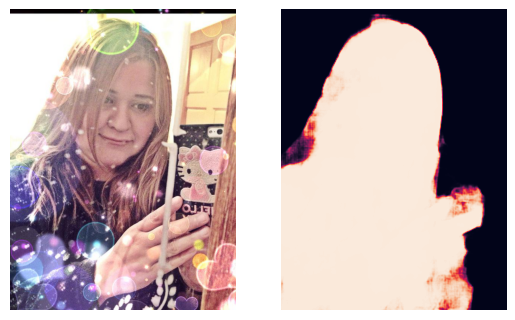

In [7]:
image_paths = sorted(Path("datasets/segmentation/images").iterdir())
mask_paths = sorted(Path("datasets/segmentation/masks").iterdir())

# Shuffle paths
paired_paths = list(zip(image_paths, mask_paths))
random.shuffle(paired_paths)
image_paths, mask_paths = zip(*paired_paths)

# Split on train and test
train_portion = 0.9
train_dataset = PortraitDataset(
    images=image_paths[:int(len(image_paths) * train_portion)],
    masks=mask_paths[:int(len(mask_paths) * train_portion)],
)
test_dataset = PortraitDataset(
    images=image_paths[int(len(image_paths) * train_portion):],
    masks=mask_paths[int(len(mask_paths) * train_portion):],
)
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

image, mask = train_dataset[0]
print("Image tensor shape:", image.size())
print("Mask tensor shape:", mask.size())
show_image_pair(image, mask)

## Простое обучение

In [37]:
reset_random_seeds()

In [38]:
stats_columns = ["Epoch", "Statistic", "Dataset", "Value"]


def show_stats(stats: pd.DataFrame, title: str):
    fig, (ax_loss, ax_jaccard) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

    sns.lineplot(
        stats[stats["Statistic"] == "Loss"],
        x="Epoch",
        y="Value",
        hue="Dataset",
        ax=ax_loss,
    )
    ax_loss.set_title("Loss")

    sns.lineplot(
        stats[stats["Statistic"] == "Jaccard"],
        x="Epoch",
        y="Value",
        hue="Dataset",
        ax=ax_jaccard,
    )
    ax_jaccard.set_title("Jaccard index")

    fig.suptitle(title)
    fig.tight_layout()

In [39]:
device = "cuda"

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")


def calc_jaccard(pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # pred is converted from logits to binary automatically with the threshold
    return jaccard(pred.cpu(), y.cpu() > jaccard.threshold)

In [41]:
def train_epoch(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        loader: torch.utils.data.DataLoader,
        show_progress: bool = True,
):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=(not show_progress)):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        metric = calc_jaccard(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(
        model: nn.Module,
        loader: torch.utils.data.DataLoader,
        show_progress: bool = True,
) -> tuple[float, float]:
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=(not show_progress)):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_sum += loss_fn(pred, y).item()
            metric_sum += calc_jaccard(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        epochs: int,
        show_detailed_progress: bool = True,
        checkpoints_dir: Path | str | None = None,
) -> pd.DataFrame:
    if checkpoints_dir is not None:
        checkpoints_dir = Path(checkpoints_dir)
        checkpoints_dir.mkdir(parents=True, exist_ok=True)

    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader, show_detailed_progress
        )
        loss_test, metric_test = test(model, test_loader, show_detailed_progress)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

        if checkpoints_dir is not None:
            torch.save(model.state_dict(), checkpoints_dir / f"epoch_{epoch_i}.pt")

    return pd.DataFrame(stats, columns=stats_columns)

### Переобучение на одном мини-батче

In [42]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())

stats = train(
    model, optimizer, train_loader, test_loader,
    epochs=100,
    show_detailed_progress=False,
)

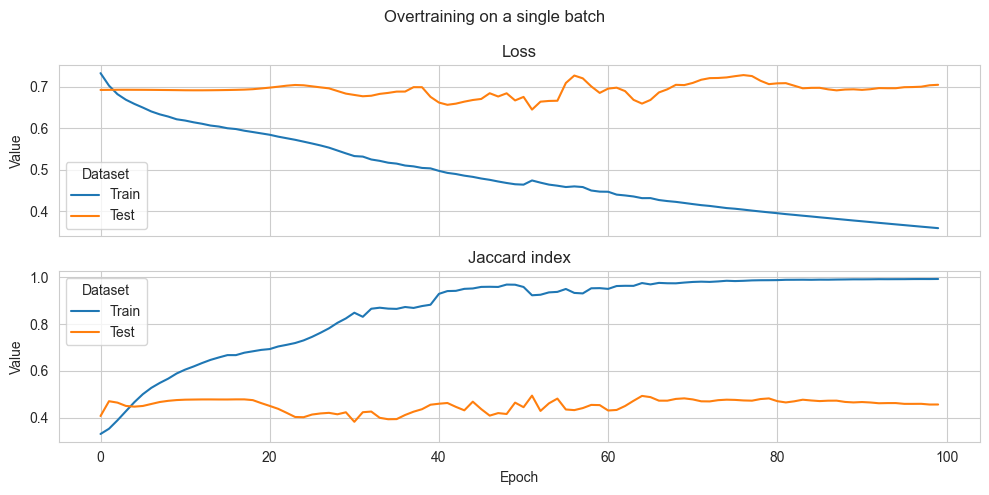

In [44]:
show_stats(stats, "Overtraining on a single batch")

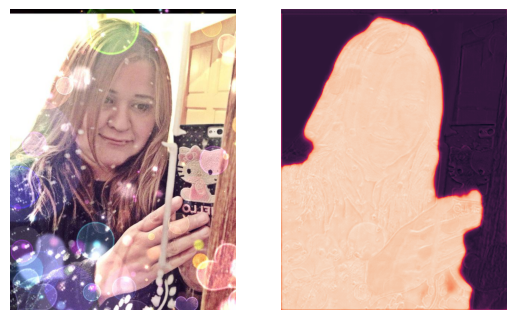

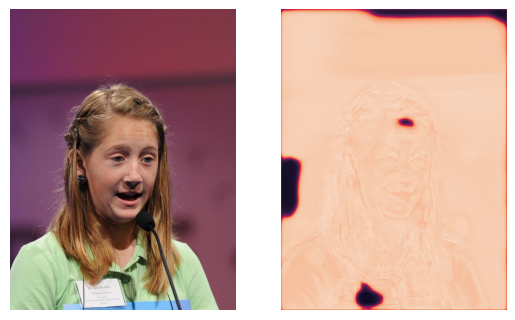

In [24]:
model.eval()

X, _ = train_dataset[0]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_image_pair(X, nn.functional.sigmoid(pred))

X, _ = test_dataset[0]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_image_pair(X, nn.functional.sigmoid(pred))

Ожидаемо, переобучившись на одном батче, получаем хороший результат на нём и плохой — на тестовых данных.

### Обучение на всех тренировочных данных

In [25]:
batch_size = 8  # Maximum possible batch size for the available GPU

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())

train(
    model, optimizer, train_loader, test_loader,
    epochs=30,
    checkpoints_dir="models/initial",
).to_csv("models/initial/stats.csv")

Как видно по графику ниже, лучшие результаты на тестовом датасете получились на 25-26 эпохах — видимо, далее модель уже стала переобучаться. Возьмём состояние модели на момент 25-ой эпохи в качестве наилучшего.

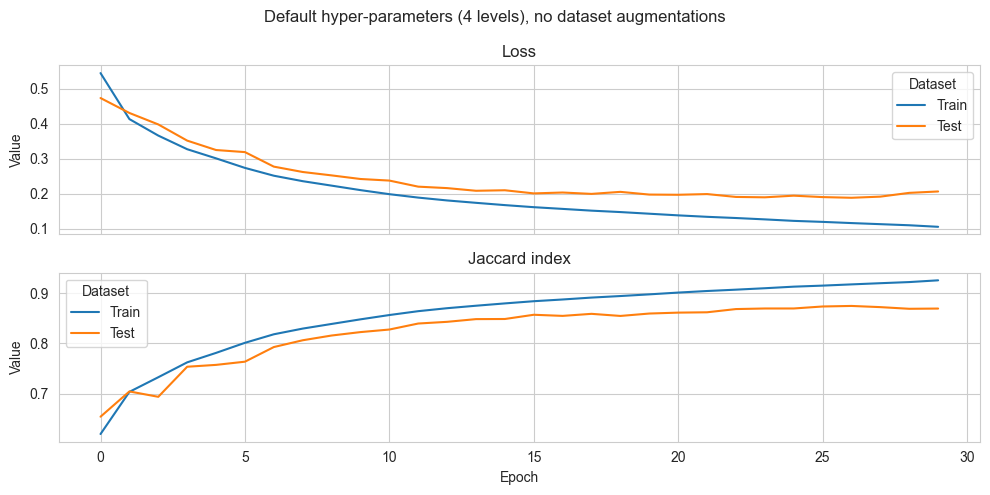

In [50]:
show_stats(pd.read_csv("models/initial/stats.csv"), "Default hyper-parameters (4 levels), no dataset augmentations")

In [27]:
model = UNet()
model.load_state_dict(torch.load(f"models/initial/epoch_25.pt"))
model.to(device).eval();

Далее представлены 3 худших (по jaccard index) результата, среди получаемых моделью на тестовых данных.

In [28]:
def show_n_worst_test_cases(model: nn.Module, n: int):
    test_metrics = []
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataset):
            pred = model(X.to(device).unsqueeze(0))[0].cpu()
            test_metrics.append((calc_jaccard(pred, y).item(), i))

    worst_cases = sorted(test_metrics)[:n]
    with torch.no_grad():
        for _, i in worst_cases:
            X, _ = test_dataset[i]
            pred = model(X.to(device).unsqueeze(0))[0].cpu()
            show_image_pair(X, nn.functional.sigmoid(pred))

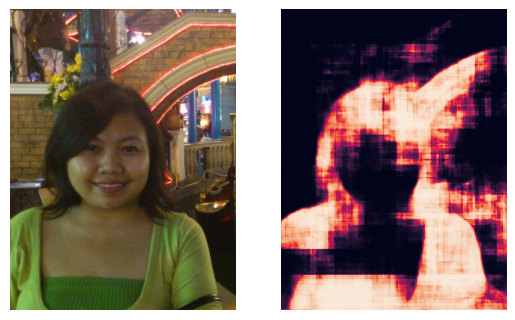

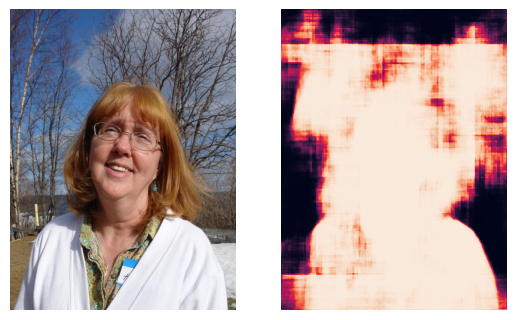

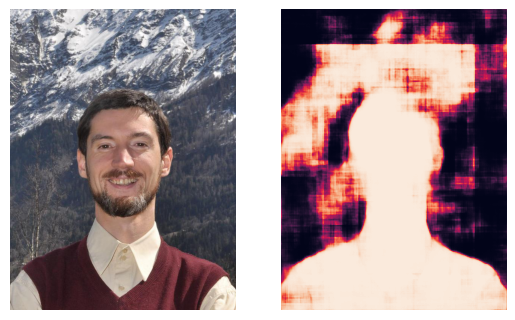

In [29]:
show_n_worst_test_cases(model, n=3)

На представленных изображениях не самые простые фоны. Также видно, что какие-то силуэты у модели выделить всё же получилось. Но кажется, что можно было добиться и лучшего.

## Улучшение качества без изменения архитектуры

In [30]:
reset_random_seeds()

### Аугментации тренировочных данных

Попробуем увеличить количество тренировочных данных при помощи аугментаций. Для каждого тренировочного изображения добавим в датасет его же, но отраженное по горизонтали и со случайно изменёнными параметрами яркости, контрастности и насыщенности.

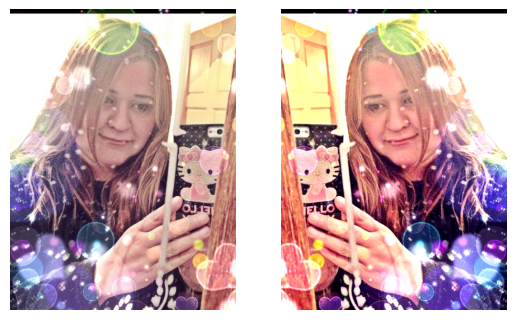

In [31]:
augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=1),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    ]
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

image, _ = train_dataset[0]
augmented_image, _ = train_dataset_augmented[0]
show_image_pair(image, augmented_image)

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset, copy.copy(train_dataset)]
)
train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

### Гиперпараметры и обучение

В качестве гиперпараметров попробуем увеличить количество уровней U-Net.

Так как тренировка на используемом оборудовании занимает достаточно много времени, попробуем всего три значения, одно из которых уже использовалось ранее (четыре уровня используются по умолчанию) — так можно будет сравнить влияние расширенного тренировочного датасета.

In [32]:
def train_search_n_levels(
        n_epochs: int,
        ns_levels: list[int],
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        save_dir: Path | str,
):
    save_dir = Path(save_dir)

    for n_levels in ns_levels:
        model = UNet(n_levels=n_levels).to(device)
        optimizer = torch.optim.Adam(model.parameters())

        model_name = f"{n_levels}_levels"
        (save_dir / model_name).mkdir(parents=True, exist_ok=True)

        stats = train(
            model, optimizer, train_loader, test_loader,
            epochs=n_epochs,
            checkpoints_dir=save_dir / model_name / "checkpoints",
        )

        show_stats(stats)
        stats.to_csv(save_dir / model_name / "stats.csv")

In [ ]:
train_search_n_levels(
    n_epochs=35,
    ns_levels=[3, 4, 5],
    train_loader=train_loader_extended,
    test_loader=test_loader,
    save_dir="models/search_n_levels",
)

Из графиков ниже следует, что:
- Аугментации тренировочных привнесли небольшие улучшения: модель с четырьмя уровнями смогла достичь значений лучше на примерно 0.02 пункта по обеим статистикам к 26-ой эпохе
- Чем больше уровней, тем лучше результат: наилучших значений достигает модель с пятью уровнями, выходя на "плато" по валидации уже к пятой эпохе (но чуть лучшие результаты все-таки достигаются на 28-ой эпохе)

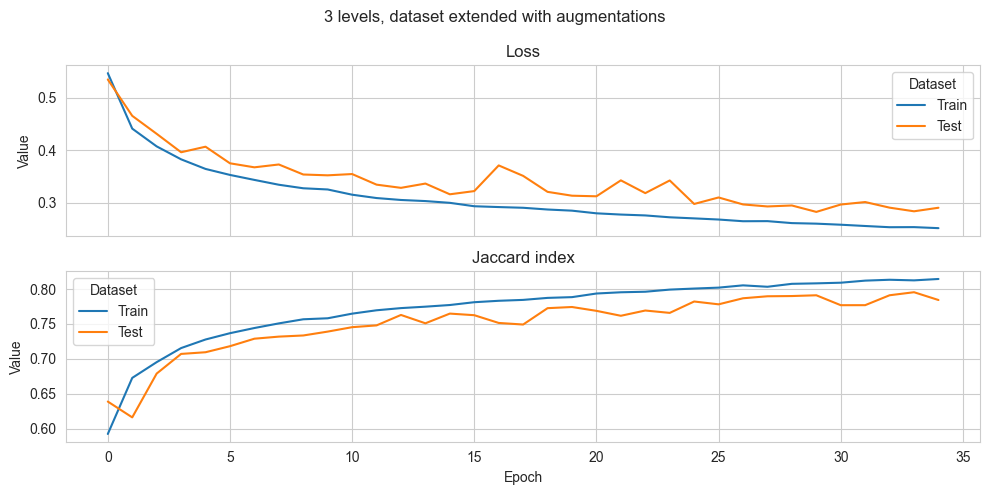

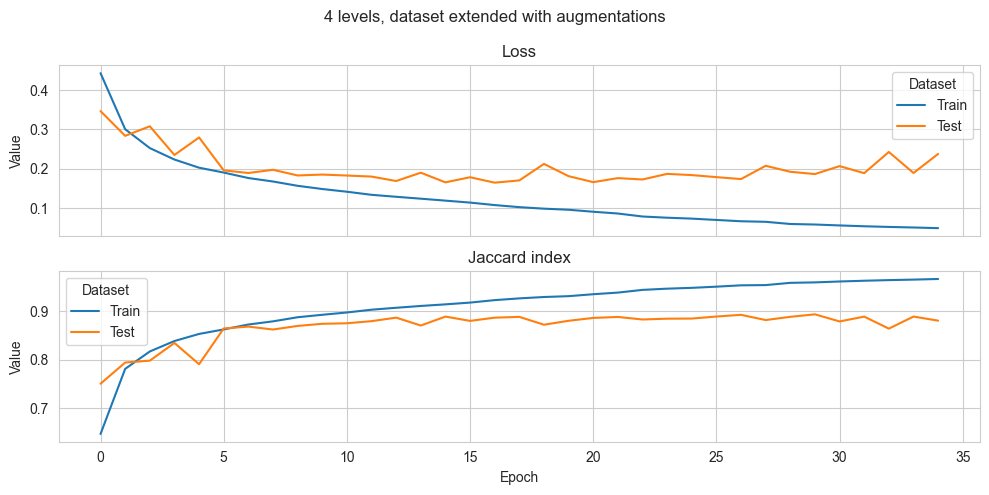

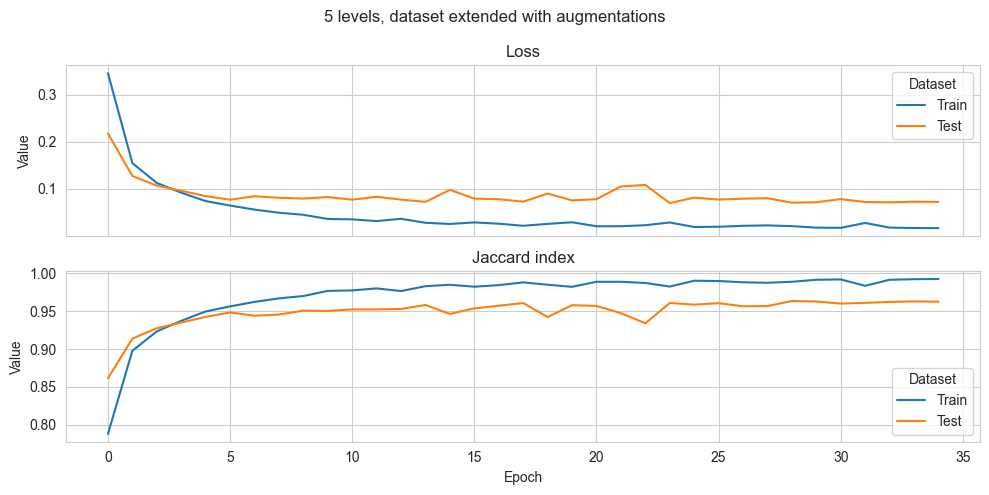

In [48]:
show_stats(pd.read_csv("models/search_n_levels/3_levels/stats.csv"), "3 levels, dataset extended with augmentations")
show_stats(pd.read_csv("models/search_n_levels/4_levels/stats.csv"), "4 levels, dataset extended with augmentations")
show_stats(pd.read_csv("models/search_n_levels/5_levels/stats.csv"), "5 levels, dataset extended with augmentations")

Возьмём в качестве наилучшей модель с пятью уровнями, натренированную на данных с аугментациями, в её состоянии на 28-ую эпоху.

In [34]:
model = UNet(n_levels=5)
model.load_state_dict(torch.load(f"models/search_n_levels/5_levels/checkpoints/epoch_28.pt"))
model.to(device).eval();

In [35]:
print("Augmented training test results (loss, jaccard):", test(model, test_loader, show_progress=False))

Augmented training test results (loss, jaccard): (0.07085886135697365, 0.9634920644760132)


Далее представлены 3 худших (по jaccard index) результата, среди получаемых выбранной моделью на тестовых данных.

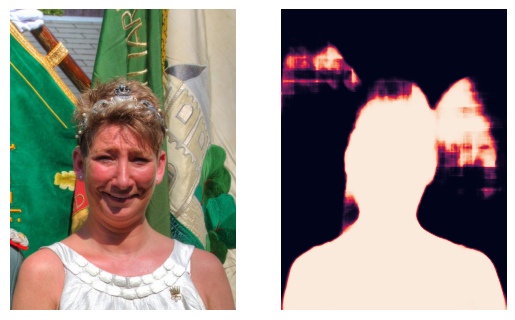

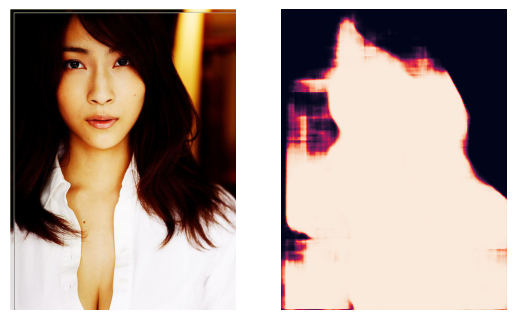

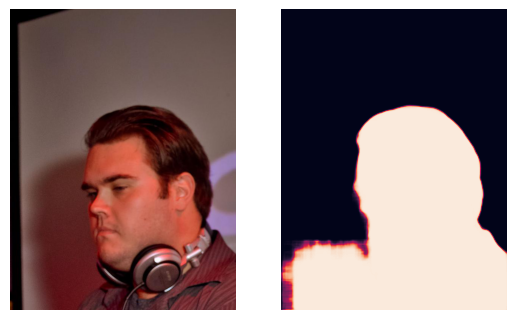

In [67]:
show_n_worst_test_cases(model, n=3)

Представленные случаи действительно тяжелые:
- на первом изображении очень неоднородный фон
- на втором — даже человеку нелегко различить, где заканчиваются чёрные волосы и начинается черный задний фон
- на третьем — выделенная моделью лишняя часть фона по цвету сливается с одеждой человека

### Test-time аугментации

Попробуем применить модель на тестовых данных следующим образом:
- передать модели тестовое изображение и его же, но отраженное по горизонтали
- усреднить полученные результаты, предварительно отразив обратно результат, полученный на аугментированном изображении

In [68]:
class UNetHFlipWrapper(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.unet = UNet(in_channels, out_channels, n_levels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward x and its flipped version to UNet
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)

        # Unflip the flipped results
        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)

        # Calculate means of the corresponding results
        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)

        return means

Flip-wrapped test results (loss, jaccard): (0.06187763400375843, 0.9670005083084107)


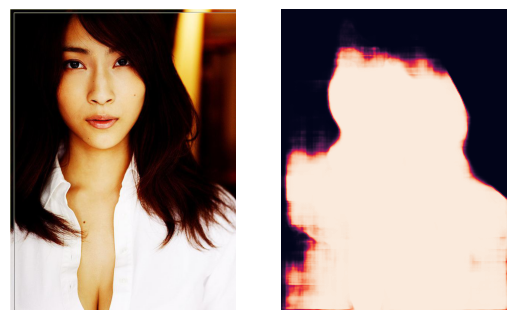

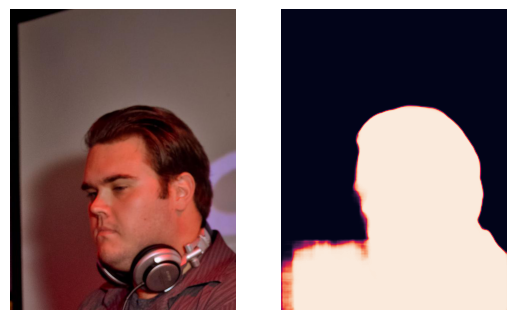

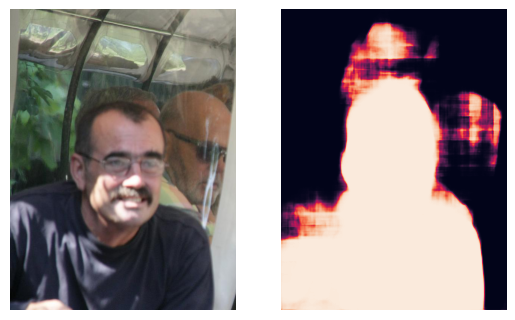

In [71]:
wrapped_model = UNetHFlipWrapper(n_levels=5).to(device)
wrapped_model.unet.load_state_dict(model.state_dict())

print("Flip-wrapped test results (loss, jaccard):", test(wrapped_model, test_loader, show_progress=False))

show_n_worst_test_cases(wrapped_model, n=3)

Тестовые результаты численно действительно улучшились, хотя и на тысячные доли jaccard index. Но два из трёх худших предсказания повторились, при этом не слишком улучшившись.

## Улучшение качества через изменение архитектуры

Попробуем добавить в "нижний" слой U-Net (тот, что имеет наименьшее разрешение, но наибольшее число каналов) больше свёрток. Возможно, это позволит добиться лучших результатов без увеличения числа уровней сети. Такой подход должен быть вычислительно более эффективным.

In [14]:
class NConvBlock(nn.Module):
    def __init__(self, n_convs: int, in_channels: int, out_channels: int, padding: int):
        super().__init__()

        # Allow arbitrary number of convolutions instead of just two
        convs = []
        for i in range(n_convs):
            convs += [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
        self.n_conv_block = nn.Sequential(*convs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.n_conv_block(x)


class LongBottomEncoder(nn.Module):
    def __init__(self, in_channels: int, n_down: int, n_bottom_convs: int, channels_factor: int = 2, padding: int = 1):
        super().__init__()

        self.enc_layers = nn.ModuleList(
            [DoubleConvBlock(in_channels, in_channels * channels_factor, padding)]
        )
        for i in range(n_down):
            in_channels *= channels_factor
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    (
                        # Use two convolutions as usual on all levels but the last one
                        DoubleConvBlock(in_channels, in_channels * channels_factor, padding)
                        if i < n_down - 1 else
                        NConvBlock(n_bottom_convs, in_channels, in_channels * channels_factor, padding)
                    ),
                )
            )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class LongBottomUNet(nn.Module):
    """Like the usual U-Net but can have an arbitrary amount of convolutions on the bottom level."""
    def __init__(self, in_channels: int = 3, out_channels: int = 1, n_levels: int = 4, n_bottom_convs: int = 2):
        super().__init__()
        self.encoder = LongBottomEncoder(in_channels=in_channels, n_down=n_levels, n_bottom_convs=n_bottom_convs)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

Попробуем натренировать модифицированную архитектуру с четырьмя свёртками вместо двух. Тренировать будем четыре уровня на датасете без аугментаций для повышения скорости обучения.

In [15]:
reset_random_seeds()

In [ ]:
model = LongBottomUNet(n_bottom_convs=4).to(device)
optimizer = torch.optim.Adam(model.parameters())

train(
    model, optimizer, train_loader, test_loader,
    epochs=30,
    checkpoints_dir="models/long_bottom",
).to_csv("models/long_bottom/stats.csv")

Получившаяся модель смогла достичь лучших результатов, чем обычная U-Net с тем же числом уровней (даже на датасете с аугментациями): удалось достичь jaccard index на тестовых данных на 0.04 пункта выше.

Но, как было ранее видно на графиках, полученных при обучении с разным числом уровней (хотя на них и отображено обучение на расширенном датасете), число уровней немного сильнее влияет на результаты: модель с пятью уровнями достигла jaccard index на 0.07 пунктов выше, чем модель с четырьмя.

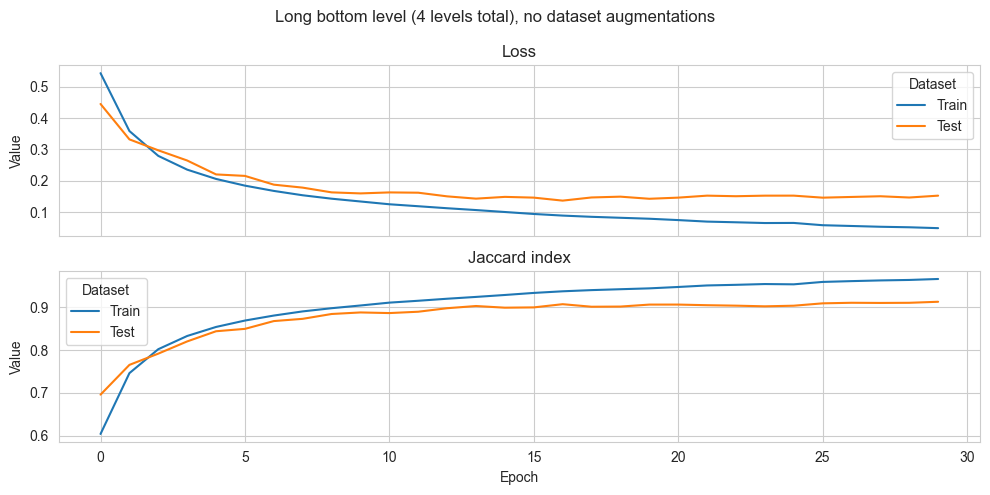

In [51]:
show_stats(pd.read_csv("models/long_bottom/stats.csv"), "Long bottom level (4 levels total), no dataset augmentations")

## Выводы

- На используемом датасете U-Net даже в стандартной конфигурации позволяет получить достаточно хорошие результаты
- Расширение тренировочных данных при помощи аугментаций, а также test-time аугментации позволяют немного (на сотые и тысячные доли значений jaccard index соответственно) улучшить получаемые результаты
- Изменение строения модели с увеличением числа тренируемых параметров (таких, как увеличение числа уровней или числа свёрток на нижнем уровне) позволяет сильнее улучшить результаты — разница всё так же измеряется в сотых долях jaccard index, но она всё же в разы выше (например, если расширение тренировочных данных посзолило улучшить результаты на 0.02, то удлинение последнего уровня — на 0.04, а увеличение числа уровней энкодера и декодера — на 0.07)